## Example 09 - Multiple vessels - edge constraints

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx 

# Start simpy environment
env = simpy.Environment()

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda)):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

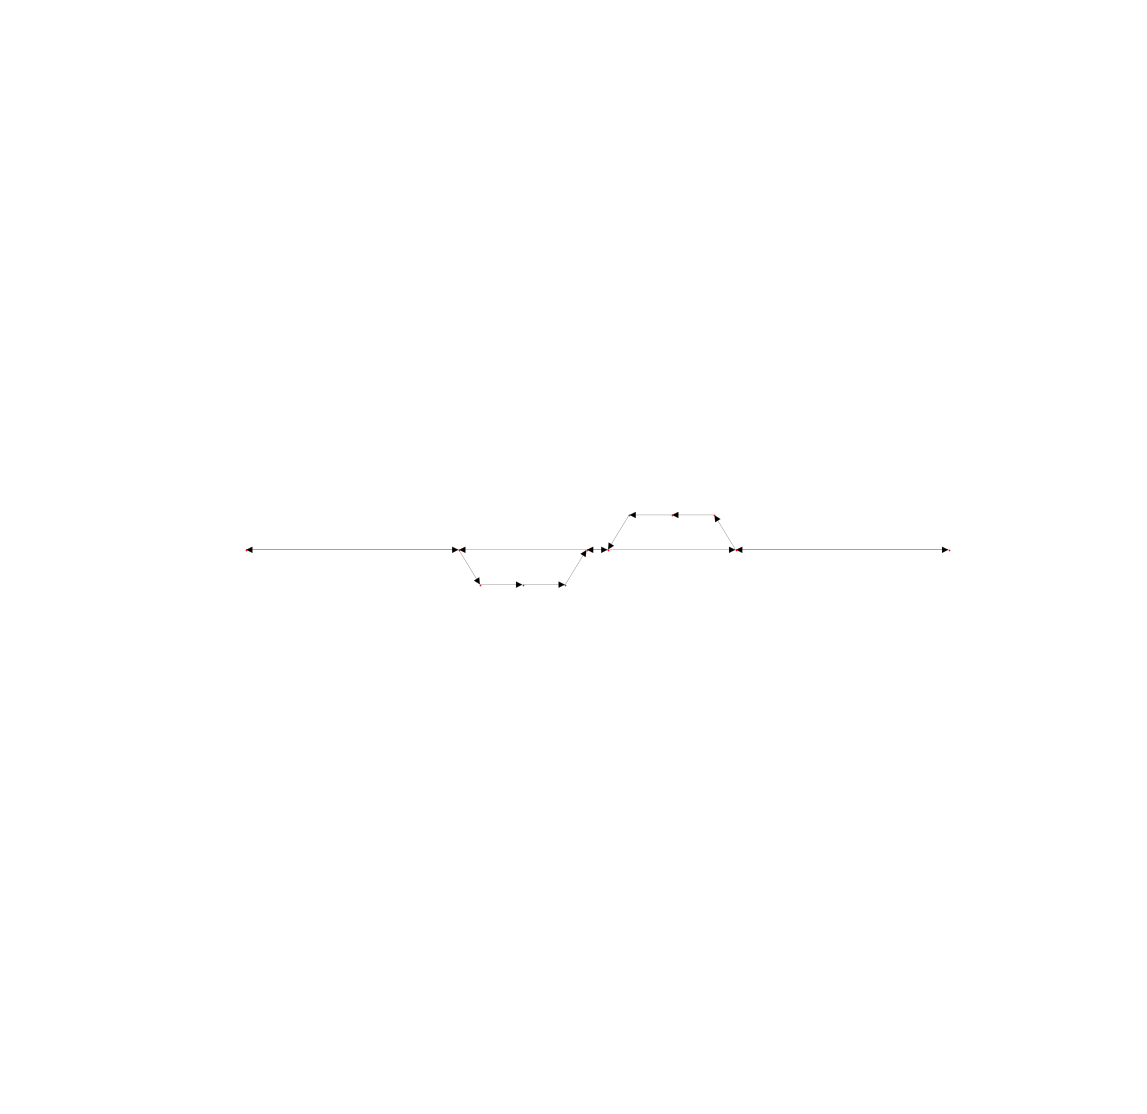

In [2]:
# Make networkx variable
graph = graph_module.Graph()
graph.graph = graph.graph.to_directed()

# Add graph nodes and edges
# Add nodes
node_1  = {"Name": "Node 1",  "Geometry": shapely.geometry.Point(00.000000, 00.000025)}
node_2  = {"Name": "Node 2",  "Geometry": shapely.geometry.Point(00.000500, 00.000025)}
node_3  = {"Name": "Node 3",  "Geometry": shapely.geometry.Point(00.000550, 00.000000)}
node_4  = {"Name": "Node 4",  "Geometry": shapely.geometry.Point(00.000650, 00.000000)}
node_5  = {"Name": "Node 5",  "Geometry": shapely.geometry.Point(00.000750, 00.000000)}
node_6  = {"Name": "Node 6",  "Geometry": shapely.geometry.Point(00.000800, 00.000025)} # lock part 1
node_7  = {"Name": "Node 7",  "Geometry": shapely.geometry.Point(00.000850, 00.000025)} # lock part 2
node_8  = {"Name": "Node 8",  "Geometry": shapely.geometry.Point(00.000900, 00.000050)}
node_9  = {"Name": "Node 9",  "Geometry": shapely.geometry.Point(00.001000, 00.000050)}
node_10 = {"Name": "Node 10", "Geometry": shapely.geometry.Point(00.001100, 00.000050)}
node_11 = {"Name": "Node 11", "Geometry": shapely.geometry.Point(00.001150, 00.000025)}
node_12 = {"Name": "Node 12", "Geometry": shapely.geometry.Point(00.001650, 00.000025)}

nodes = [node_1, node_2, node_3, node_4, node_5, node_6, 
         node_7, node_8, node_9, node_10, node_11, node_12]

for node in nodes:
    graph.graph.add_node(node["Name"], 
                         Geometry = node["Geometry"], 
                         Position = (node["Geometry"].x, node["Geometry"].y))

# Add edges
edge_1_2   = [ node_1,  node_2, "Canal", simpy.Resource(env, capacity = math.inf)]
edge_2_1   = [ node_2,  node_1, "Canal", simpy.Resource(env, capacity = math.inf)]

edge_2_3   = [ node_2,  node_3, "Canal", simpy.Resource(env, capacity = math.inf)]
edge_6_2   = [ node_6,  node_2, "Canal", simpy.Resource(env, capacity = math.inf)]
edge_5_6   = [ node_5,  node_6, "Funnel", simpy.Resource(env, capacity = 1)]

edge_3_4   = [ node_3,  node_4, "Waiting Area", simpy.Resource(env, capacity = 1)]
edge_4_5   = [ node_4,  node_5, "Line-Up Area", simpy.Resource(env, capacity = 1)]

shared_resource = simpy.PriorityResource(env, capacity = 1)
edge_6_7   = [ node_6,  node_7, "Lock", shared_resource]
edge_7_6   = [ node_7,  node_6, "Lock", shared_resource]

edge_10_9  = [node_10,  node_9, "Line-Up Area", simpy.Resource(env, capacity = 1)]
edge_9_8   = [ node_9,  node_8, "Waiting Area", simpy.Resource(env, capacity = 1)]

edge_8_7   = [ node_8,  node_7, "Funnel", simpy.Resource(env, capacity = 1)]
edge_11_10 = [node_11, node_10, "Canal", simpy.Resource(env, capacity = math.inf)]
edge_7_11  = [ node_7, node_11, "Canal", simpy.Resource(env, capacity = math.inf)]

edge_11_12 = [node_11, node_12, "Canal", simpy.Resource(env, capacity = math.inf)]
edge_12_11 = [node_12, node_11, "Canal", simpy.Resource(env, capacity = math.inf)]

edges = [edge_1_2, edge_2_1,
         edge_2_3, edge_6_2, edge_5_6,
         edge_3_4, edge_4_5,
         edge_6_7, edge_7_6,
         edge_10_9, edge_9_8,
         edge_8_7, edge_11_10, edge_7_11,
         edge_11_12, edge_12_11]

for edge in edges:
    graph.graph.add_edge(edge[0]["Name"], edge[1]["Name"], 
                         Object = edge[2], weight = 1, Resources = edge[3])
    
# Plot the graph
graph.plot(size = [15, 15], arrowsize = 15)

### Make vessels and paths

In [3]:
paths = []

path = nx.dijkstra_path(graph.graph, node_1["Name"], node_12["Name"])
paths.append(path)
paths.append(path)

path = nx.dijkstra_path(graph.graph, node_12["Name"], node_1["Name"])
paths.append(path)
paths.append(path)

In [4]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Log, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

vessels = []
for i in range(4):
    vessel = TransportResource(**data_vessel)
    vessel.name = "Vessel " + str(i + 1)
    vessels.append(vessel)

### Start simulation

In [5]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(graph.graph, "Geometry")[vessel.route[-1]]:
            break

In [6]:
# Add graph to environment
resources = []
for edge in graph.graph.edges(data = True):
    if edge[2]["Object"] == "Canal":
        resources.append(math.inf)
    else:
        resources.append(1)

#graph.add_resources(list(graph.graph.edges), resources, env)
env.FG = graph.graph

for i, vessel in enumerate(vessels):
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = paths[i]
    
    vessel.geometry = nx.get_node_attributes(graph.graph, "Geometry")[paths[i][0]]

    # Add the movements of the vessel to the simulation
    env.process(start(env, vessel))

env.epoch = datetime.datetime.now()

env.run()

### Obtain vessel log information
The cel below uses the vessel log. The core function *log_entry* is used, which takes four arguments:

- **Log.** A text to describe what is logged.
- **t.** The timestamp.
- **Value.**  The value for the log (for sailing this is the distance).
- **Geometry** The location of the vessel while loggin.

In [7]:
vessel_log = pd.DataFrame.from_dict(vessels[0].log)
vessel_log

,Message,Timestamp,Value,Geometry
0,Start sailing,0.000000,,POINT (0 2.5e-05)
1,Sailing from node Node 1 to node Node 2,55.659745,55.6597,POINT (0.0005 2.5e-05)
2,Sailing from node Node 2 to node Node 3,61.874385,6.21464,POINT (0.00055 0)
3,Sailing from node Node 3 to node Node 4,73.006334,11.1319,POINT (0.00065 0)
4,Sailing from node Node 4 to node Node 5,84.138283,11.1319,POINT (0.00075 0)
5,Sailing from node Node 5 to node Node 6,90.352922,6.21464,POINT (0.0008 2.5e-05)
6,Sailing into lock,690.352922,300,POINT (0.0008 2.5e-05)
7,Converting chamber,990.352922,1200,POINT (0.000825 2.5e-05)
8,Sailing out of lock,990.352922,300,POINT (0.0008 2.5e-05)
9,Sailing from node Node 7 to node Node 11,1323.748769,33.3958,POINT (0.00115 2.5e-05)


In [8]:
vessel_log = pd.DataFrame.from_dict(vessels[1].log)
vessel_log

,Message,Timestamp,Value,Geometry
0,Start sailing,0.000000,,POINT (0 2.5e-05)
1,Sailing from node Node 1 to node Node 2,55.659745,55.6597,POINT (0.0005 2.5e-05)
2,Sailing from node Node 2 to node Node 3,61.874385,6.21464,POINT (0.00055 0)
3,Waiting to pass edge Node 3 - Node 4,84.138283,0,POINT (0.00055 0)
4,Sailing from node Node 3 to node Node 4,95.270232,11.1319,POINT (0.00065 0)
5,Sailing from node Node 4 to node Node 5,106.402181,11.1319,POINT (0.00075 0)
6,Sailing from node Node 5 to node Node 6,112.616820,6.21464,POINT (0.0008 2.5e-05)
7,Doors closing,4290.352922,600,POINT (0.0008 2.5e-05)
8,Converting chamber,4890.352922,1200,POINT (0.000825 2.5e-05)
9,Doors opening,6090.352922,600,POINT (0.0008 2.5e-05)


In [9]:
vessel_log = pd.DataFrame.from_dict(vessels[2].log)
vessel_log

,Message,Timestamp,Value,Geometry
0,Start sailing,0.000000,,POINT (0.00165 2.5e-05)
1,Sailing from node Node 12 to node Node 11,55.659745,55.6597,POINT (0.00115 2.5e-05)
2,Sailing from node Node 11 to node Node 10,61.874385,6.21464,POINT (0.0011 5e-05)
3,Sailing from node Node 10 to node Node 9,73.006334,11.1319,POINT (0.001 5e-05)
4,Sailing from node Node 9 to node Node 8,84.138283,11.1319,POINT (0.0009 5e-05)
5,Sailing from node Node 8 to node Node 7,90.352922,6.21464,POINT (0.00085 2.5e-05)
6,Sailing into lock,90.352922,300,POINT (0.00085 2.5e-05)
7,Converting chamber,390.352922,1200,POINT (0.000825 2.5e-05)
8,Sailing out of lock,390.352922,300,POINT (0.00085 2.5e-05)
9,Sailing from node Node 6 to node Node 2,723.748769,33.3958,POINT (0.0005 2.5e-05)


In [10]:
vessel_log = pd.DataFrame.from_dict(vessels[3].log)
vessel_log

,Message,Timestamp,Value,Geometry
0,Start sailing,0.000000,,POINT (0.00165 2.5e-05)
1,Sailing from node Node 12 to node Node 11,55.659745,55.6597,POINT (0.00115 2.5e-05)
2,Sailing from node Node 11 to node Node 10,61.874385,6.21464,POINT (0.0011 5e-05)
3,Waiting to pass edge Node 10 - Node 9,84.138283,0,POINT (0.0011 5e-05)
4,Sailing from node Node 10 to node Node 9,95.270232,11.1319,POINT (0.001 5e-05)
5,Sailing from node Node 9 to node Node 8,106.402181,11.1319,POINT (0.0009 5e-05)
6,Sailing from node Node 8 to node Node 7,112.616820,6.21464,POINT (0.00085 2.5e-05)
7,Doors closing,1290.352922,600,POINT (0.00085 2.5e-05)
8,Converting chamber,1890.352922,1200,POINT (0.000825 2.5e-05)
9,Doors opening,3090.352922,600,POINT (0.00085 2.5e-05)


### Visualization of path
If you get an error regarding ffmpeg use [this](https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available) answer. You have to install ffmpeg in your Conda environment. It can be done using the following command.

```bash
#Install ffmpeg using Conda
conda install -c conda-forge ffmpeg
```

In [11]:
for vessel in vessels:
    geom_x = []
    geom_y = []

    for geom in vessel.log["Geometry"]:
        geom_x.append(geom.x)
        geom_y.append(geom.y)

    vessel.log["Geometry - x"] = geom_x
    vessel.log["Geometry - y"] = geom_y

In [12]:
time_stamp_min = []
time_stamp_max = []

for vessel in vessels:
    time_stamp_min.append(min(vessel.log["Timestamp"]))
    time_stamp_max.append(max(vessel.log["Timestamp"]))

time_stamp_min = min(time_stamp_min)
time_stamp_max = max(time_stamp_max)

stepsize = 1
steps = int(np.floor((time_stamp_max - time_stamp_min) / stepsize))

timestamps_t = np.linspace(time_stamp_min, time_stamp_max, steps)
for vessel in vessels:
    vessel.log["timestamps_x"] = np.interp(timestamps_t, vessel.log["Timestamp"], vessel.log["Geometry - x"])
    vessel.log["timestamps_y"] = np.interp(timestamps_t, vessel.log["Timestamp"], vessel.log["Geometry - y"])

Wall time: 4min 13s


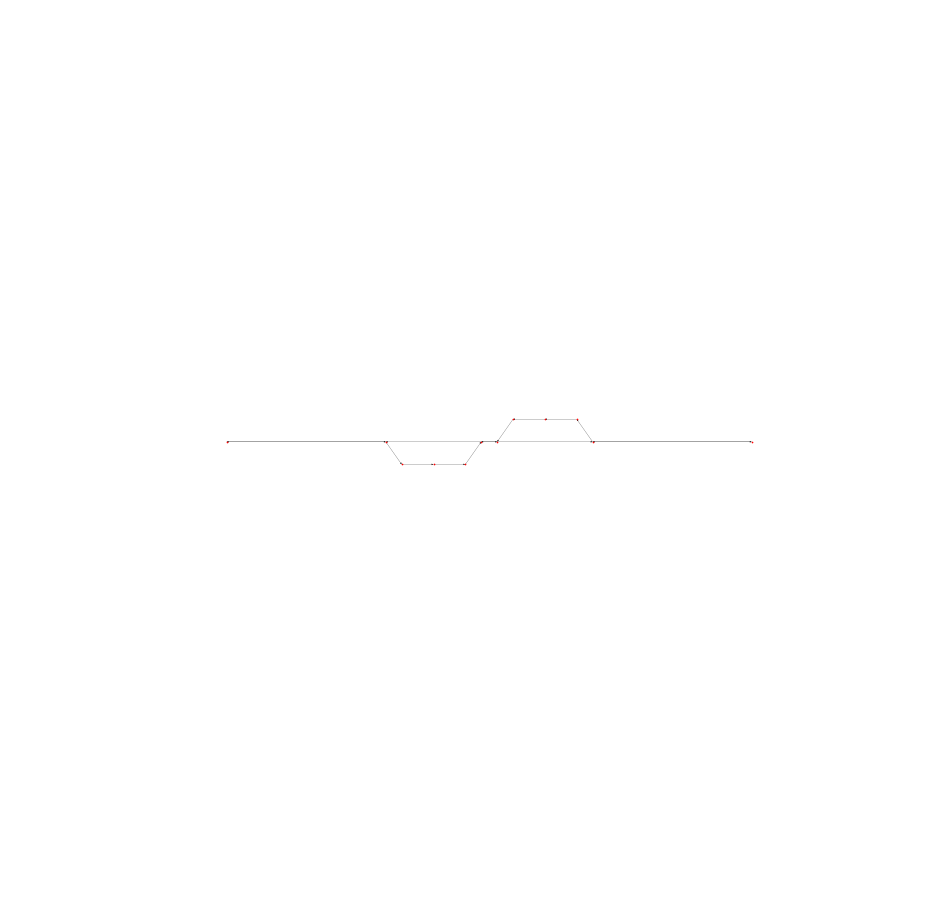

In [13]:
%%time

# Make the animation
fig = plt.figure(figsize = [12, 12])

nx.draw(graph.graph, nx.get_node_attributes(graph.graph, 'Position'), 
        with_labels = False, 
        node_size = 0.5,
        font_size = 2, 
        width = 0.2, 
        arrowsize = 3)


location_1, = plt.plot([], [], color = "#1f77b4", marker = "o", markersize=15)
path_1,     = plt.plot([], [], color = "#1f77b4")

location_2, = plt.plot([], [], color = "#ff7f0e", marker = "o", markersize=15)
path_2,     = plt.plot([], [], color = "#ff7f0e")

location_3, = plt.plot([], [], color = "#2ca02c", marker = "o", markersize=15)
path_3,     = plt.plot([], [], color = "#2ca02c")

location_4, = plt.plot([], [], color = "#d62728", marker = "o", markersize=15)
path_4,     = plt.plot([], [], color = "#d62728")

location_5, = plt.plot([], [], color = "#9467bd", marker = "o", markersize=15)
path_5,     = plt.plot([], [], color = "#9467bd")

def init():
    location_1.set_data([], [])
    path_1.set_data([], [])
    
    location_2.set_data([], [])
    path_2.set_data([], [])
    
    location_3.set_data([], [])
    path_3.set_data([], [])
    
    location_4.set_data([], [])
    path_4.set_data([], [])
    
    location_5.set_data([], [])
    path_5.set_data([], [])

def animate(i):
    for j, vessel in enumerate(vessels):
        this_x = [vessel.log["timestamps_x"][i]]
        this_y = [vessel.log["timestamps_y"][i]]

        past_x = [x for x in vessel.log["timestamps_x"][:i]]
        past_y = [y for y in vessel.log["timestamps_y"][:i]]

        if j == 0:
            location_1.set_data(this_x, this_y)
            path_1.set_data(past_x, past_y)
        elif j == 1:
            location_2.set_data(this_x, this_y)
            path_2.set_data(past_x, past_y)
        elif j == 2:
            location_3.set_data(this_x, this_y)
            path_3.set_data(past_x, past_y)
        elif j == 3:
            location_4.set_data(this_x, this_y)
            path_4.set_data(past_x, past_y)
        elif j == 4:
            location_5.set_data(this_x, this_y)
            path_5.set_data(past_x, past_y)

    return location_1, location_2, location_3, location_4, location_5, path_1, path_2, path_3, path_4, path_5
    
        
ani = animation.FuncAnimation(fig, animate, np.arange(0, len(timestamps_t)), init_func=init)
ani.save('Lock - example 10.mp4', fps=5)